In [9]:
import pandas as pd
import numpy as np
import torch
import time
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import optuna

# Set the random state for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 데이터 로드 및 전처리
data_path = 'C:\\Users\\user\\Desktop\\PV\\실험\\전처리_v3\\Sejong_v3.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])

features = data.columns.drop(['Date', 'PVGeneration'])
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# 데이터 분할
train_data = data[data['Date'] < pd.to_datetime('2019-01-01 08:00:00')]
test_data = data[(data['Date'] >= pd.to_datetime('2019-01-01 08:00:00')) & (data['Date'] <= pd.to_datetime('2019-12-31 18:00:00'))]
val_size = int(0.1 * len(train_data))
train_df, val_df = torch.utils.data.random_split(train_data, [len(train_data) - val_size, val_size])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################################################################################################################################################
# TCN 하이퍼파라미터 설정
hyperparameters = {
    'num_channels': [25, 50, 75],
    'kernel_size': 3,
    'dropout_rate': 0.2,
    'output_size': 1,
    'num_epochs': 100,
    'window_size': 36,
    'batch_size': 64,
    'learning_rate': 0.001,
    'forecast_horizon': 11,  # 추가: 다음 11시간을 예측
    'input_size': len(features)
}

##########################################################################################################################################################################
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size, forecast_horizon):
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.features = df.columns.drop(['Date', 'PVGeneration'])

    def __len__(self):
        return len(self.df) - self.window_size - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.df.loc[idx:idx + self.window_size - 1, self.features].values
        y = self.df.loc[idx + self.window_size:idx + self.window_size + self.forecast_horizon - 1, 'PVGeneration'].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



train_data_subset = train_data.iloc[train_df.indices].reset_index(drop=True)
val_data_subset = train_data.iloc[val_df.indices].reset_index(drop=True)

train_dataset = TimeSeriesDataset(train_data_subset, hyperparameters['window_size'], hyperparameters['forecast_horizon'])
val_dataset = TimeSeriesDataset(val_data_subset, hyperparameters['window_size'], hyperparameters['forecast_horizon'])
test_dataset = TimeSeriesDataset(test_data, hyperparameters['window_size'], hyperparameters['forecast_horizon'])


train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

##########################################################################################################################################################################
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x
        if self.downsample is not None:
            res = self.downsample(res)

        # Ensure out and res have the same shape
        if out.size(2) != res.size(2):
            # Adjust the size if necessary
            res = nn.functional.interpolate(res, size=out.size(2), mode='linear', align_corners=False)

        return self.relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, dropout=dropout)]
        self.tcn = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size * hyperparameters['forecast_horizon'])  # 출력 크기 수정

    def forward(self, x):
        x = x.transpose(1, 2)  # [batch_size, seq_len, channels] -> [batch_size, channels, seq_len]
        y = self.tcn(x)
        o = self.linear(y[:, :, -1])
        o = o.view(x.size(0), -1)  # 예측된 타임 스텝 수에 맞게 출력 조정
        return o


##########################################################################################################################################################################
def nrmse(predictions, targets):
    rmse = sqrt(mean_squared_error(predictions, targets))
    return rmse / np.mean(targets)

def nmae(predictions, targets):
    mae_value = mean_absolute_error(predictions, targets)
    return mae_value / np.mean(targets)

def r2(predictions, targets):
    return r2_score(targets, predictions)

##########################################################################################################################################################################
def evaluate_model(model, test_loader, device, prediction_steps=11):
    model.eval()
    metrics_per_step = []

    with torch.no_grad():
        for step in range(prediction_steps):
            all_targets = []
            all_outputs = []
            for data, target in test_loader:
                data = data.to(device)
                output = model(data)  # output shape is [batch_size, forecast_horizon]
                output = output.view(-1, prediction_steps)  # reshaping to separate predictions
                target = target.view(-1)  # flatten target to match output's shape
                if step < target.size(0):  # check if there's enough data for this step
                    all_outputs.append(output[:, step].cpu().numpy())  # select prediction for the current step
                    all_targets.append(target.cpu().numpy())

            all_outputs = np.concatenate(all_outputs)
            all_targets = np.concatenate(all_targets)

            # Now ensure all_outputs and all_targets have the same length
            min_length = min(len(all_outputs), len(all_targets))
            all_outputs = all_outputs[:min_length]
            all_targets = all_targets[:min_length]

            avg_rmse = sqrt(mean_squared_error(all_targets, all_outputs))
            avg_nrmse = nrmse(np.array(all_outputs), np.array(all_targets))
            avg_nmae = nmae(np.array(all_outputs), np.array(all_targets))
            avg_r2 = r2(np.array(all_outputs), np.array(all_targets))

            metrics_per_step.append((avg_rmse, avg_nrmse, avg_nmae, avg_r2))
            print(f"Step {step+1}: RMSE: {avg_rmse}, NRMSE: {avg_nrmse}, NMAE: {avg_nmae}, R^2: {avg_r2}")

    # Calculate and return average metrics across all steps
    avg_rmse = np.mean([m[0] for m in metrics_per_step])
    avg_nrmse = np.mean([m[1] for m in metrics_per_step])
    avg_nmae = np.mean([m[2] for m in metrics_per_step])
    avg_r2 = np.mean([m[3] for m in metrics_per_step])
    print(f"Average: RMSE: {avg_rmse}, NRMSE: {avg_nrmse}, NMAE: {avg_nmae}, R^2: {avg_r2}")

    return avg_rmse, avg_nrmse, avg_nmae, avg_r2


##########################################################################################################################################################################
mse_loss = nn.MSELoss()

##########################################################################################################################################################################
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 4)
    num_channels = [trial.suggest_int(f'n_channels_{i}', 16, 128) for i in range(num_layers)]
    kernel_size = trial.suggest_int('kernel_size', 2, 8)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_int('batch_size', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model = TCN(hyperparameters['input_size'], hyperparameters['output_size'], num_channels, kernel_size, dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(hyperparameters['num_epochs']):
        model.train()
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = mse_loss(outputs, labels)  # 직접 outputs.squeeze(-1)을 사용하지 않음
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seqs, labels in val_loader:
                seqs, labels = seqs.to(device), labels.to(device)
                outputs = model(seqs)
                
                # Directly use outputs without indexing a third dimension
                loss = mse_loss(outputs, labels)
                val_loss += loss.item()

    return val_loss / len(val_loader)

##########################################################################################################################################################################
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 100)
best_params = study.best_trial.params

best_model = TCN(hyperparameters['input_size'], hyperparameters['output_size'], [best_params[f'n_channels_{i}'] for i in range(best_params['num_layers'])], best_params['kernel_size'], best_params['dropout_rate']).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

##########################################################################################################################################################################
for epoch in range(hyperparameters['num_epochs']):  # num_epochs를 사용하여 반복
    best_model.train()  # 모델을 학습 모드로 설정
    total_loss = 0
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(seqs).squeeze()  # 차원 축소
        loss = mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Test DataLoader 준비 - 수정된 부분
test_dataset = TimeSeriesDataset(test_data, hyperparameters['window_size'], hyperparameters['forecast_horizon'])  # forecast_horizon 추가
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

# 모델 평가
avg_rmse, avg_nrmse, avg_nmae, avg_r2 = evaluate_model(best_model, test_loader, device)



[I 2024-03-12 11:32:50,048] A new study created in memory with name: no-name-5f7a3f06-5165-45db-a3eb-a1253e4aef0d
[I 2024-03-12 11:35:53,392] Trial 0 finished with value: 0.10371959209442139 and parameters: {'num_layers': 3, 'n_channels_0': 113, 'n_channels_1': 64, 'n_channels_2': 42, 'kernel_size': 6, 'dropout_rate': 0.1955489801186745, 'batch_size': 44, 'learning_rate': 0.0010072610972662824}. Best is trial 0 with value: 0.10371959209442139.
[I 2024-03-12 11:38:45,881] Trial 1 finished with value: 0.07521308745656695 and parameters: {'num_layers': 3, 'n_channels_0': 107, 'n_channels_1': 52, 'n_channels_2': 47, 'kernel_size': 5, 'dropout_rate': 0.3287172257359855, 'batch_size': 124, 'learning_rate': 0.02978860324032294}. Best is trial 1 with value: 0.07521308745656695.
[I 2024-03-12 11:43:49,534] Trial 2 finished with value: 0.07882108241319656 and parameters: {'num_layers': 4, 'n_channels_0': 93, 'n_channels_1': 72, 'n_channels_2': 27, 'n_channels_3': 114, 'kernel_size': 8, 'dropout_

Epoch 1, Loss: 109.04375876280768
Epoch 2, Loss: 0.07932918056331832
Epoch 3, Loss: 0.07931025775855985
Epoch 4, Loss: 0.07932784485405889
Epoch 5, Loss: 0.07960106368208754
Epoch 6, Loss: 0.07937982331576018
Epoch 7, Loss: 0.07914383786505666
Epoch 8, Loss: 0.07916750656119709
Epoch 9, Loss: 0.07914813967614338
Epoch 10, Loss: 0.07921717893974535
Epoch 11, Loss: 0.07923952233174751
Epoch 12, Loss: 0.07913383199223156
Epoch 13, Loss: 0.07910982275317455
Epoch 14, Loss: 0.07931816064078233
Epoch 15, Loss: 0.07906489986284025
Epoch 16, Loss: 0.07914085634823503
Epoch 17, Loss: 0.07900869486660793
Epoch 18, Loss: 0.07903050605593057
Epoch 19, Loss: 0.07899039906674418
Epoch 20, Loss: 0.07901662523890364
Epoch 21, Loss: 0.07912280821594699
Epoch 22, Loss: 0.07918612106606879
Epoch 23, Loss: 0.0792343734667219
Epoch 24, Loss: 0.07931947605363254
Epoch 25, Loss: 0.07911709246450457
Epoch 26, Loss: 0.0790270591347382
Epoch 27, Loss: 0.07910331248723228
Epoch 28, Loss: 0.0790451494013441
Epoch

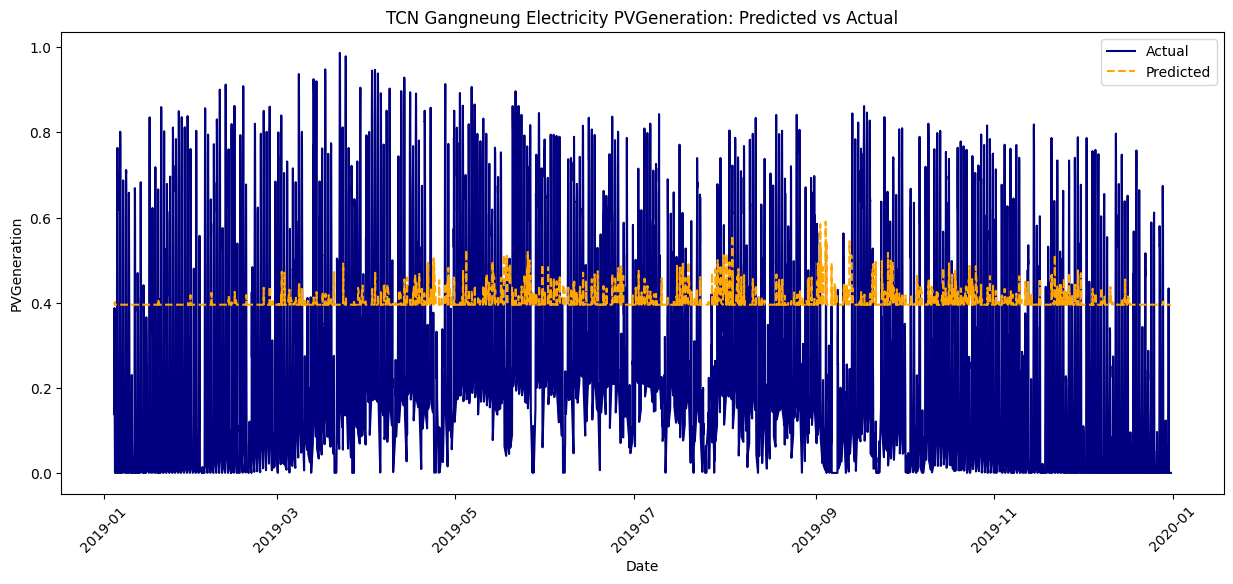

In [10]:
import matplotlib.pyplot as plt
import torch

# 모델을 평가 모드로 설정
best_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = best_model(data)
        # output을 1차원 배열로 변환하여 predictions 리스트에 추가
        # 각 예측 시퀀스에 대한 첫 번째 예측값만 사용하되, 항상 1차원 배열로 처리
        pred = output[:, 0].detach().cpu().numpy()  # 1차원 배열을 유지
        # pred가 스칼라 값이면 리스트로 변환하여 extend
        predictions.extend(pred.flatten() if pred.ndim > 0 else [pred.item()])
        # 실제값 처리 시에도 동일한 방식 적용
        act = target[:, 0].cpu().numpy()
        actuals.extend(act.flatten() if act.ndim > 0 else [act.item()])

# 시간 데이터 추출 및 배열 길이 조정
dates = test_data['Date'].iloc[hyperparameters['window_size']:].values
# 예측값의 길이에 맞게 dates 배열 조정
dates = dates[:len(predictions)]

# 그래프 크기 설정
plt.figure(figsize=(15, 6))

# 실제값과 예측값을 그래프에 표시
plt.plot(dates, actuals, label='Actual', color='navy')
plt.plot(dates, predictions, label='Predicted', color='orange', linestyle='--')

# 그래프 제목과 레이블 설정
plt.title('TCN Gangneung Electricity PVGeneration: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('PVGeneration')
plt.xticks(rotation=45)
plt.legend()

# 그래프 표시
plt.show()


========================================================